In [1]:
#!/usr/bin/env python
"""
@author: Jayant Gupta"
last update: 02.06.2021
"""

'\n@author: Jayant Gupta"\nlast update: 02.06.2021\n'

In [2]:
# ==================== Import necessary libraries ==================== 
import tensorflow as tf
import os
import random
import numpy as np
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from models import *
from generators import *

from tqdm import tqdm
import json

from skimage.io import imread, imshow, show
from skimage.transform import resize
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split

from PIL import Image

# Handles reading large number of files.
Image.MAX_IMAGE_PIXELS = 219494175 

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



In [3]:
# ==================== Generate dataset X-Y filepath pairs ==================== 
seed = 42
np.random.seed = seed
tf.random.set_seed(seed)

IMG_HEIGHT = 1024
IMG_WIDTH = 1024
IMG_CHANNELS = 3
IMG_INDEX = "RGB"

IN_FOLDERS = ["MN_raster_Hennepin_South"]

# This function creates a dictionary to store images and their mask.
# This function is curated to handle train images *.tif format and 
# mask file in *.jpeg format
def get_in_out_dict(img_dir=json.load(open('config.json'))['filepaths']['default_reprojections_dir'], 
                    mask_dir=json.load(open('config.json'))['filepaths']['default_masks_dir'], 
                    indices_dir=None, 
                    index_type=None,
                    in_folder=''):
    in_out_dict = []
    img_path = os.path.join(img_dir, in_folder) # img_dir/in_folder
    for img_filename in os.listdir(img_path):
        in_file = os.path.join(img_path, img_filename) # img_dir/in_folder/img_filename
        if os.path.isdir(in_file):
            if IMG_CHANNELS > 3:
                in_out_dict += get_in_out_dict(indices_dir=indices_dir, index_type=IMG_INDEX, in_folder=os.path.join(in_folder, img_filename))
            else:
                in_out_dict += get_in_out_dict(in_folder=os.path.join(in_folder, img_filename))
        if in_file.endswith(".tif") is not True:
            continue
        filename = img_filename.split('.')[0]
        filenames = []
        filenames.append(in_file)
        if IMG_CHANNELS > 3:
            indices_path = os.path.join(indices_dir, in_folder) # indices_dir/in_folder
            filenames.append(
                os.path.join(indices_path, [index for index in os.listdir(indices_path) if filename in index and Index_Type in index][0]))
        mask_path = os.path.join(mask_dir, in_folder) # mask_path/in_folder
        filenames.append(
            os.path.join(mask_path, [mask for mask in os.listdir(mask_path) if filename in mask][0]))
        in_out_dict.append(filenames)

    return in_out_dict

in_out_dict=[]
for in_folder in IN_FOLDERS:
    if IMG_CHANNELS > 3:
        indices_dir = json.load(open('config.json'))['filepaths']['default_indices_dir']
        in_out_dict += get_in_out_dict(in_folder=in_folder, indices_dir=indices_dir, index_type=IMG_INDEX)
    else:
        in_out_dict += get_in_out_dict(in_folder=in_folder)

in_out_dict = np.array(in_out_dict)
X_in = in_out_dict[:,0]
Y_in = in_out_dict[:,1]
print(X_in.shape, Y_in.shape)
print(X_in[0:5], Y_in[0:5])

(724,) (724,)
['outputs/reprojections/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_0-0.tif'
 'outputs/reprojections/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_0-2048.tif'
 'outputs/reprojections/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_0-4096.tif'
 'outputs/reprojections/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_0-6144.tif'
 'outputs/reprojections/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_10240-0.tif'] ['outputs/masks/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_0-0.jpeg'
 'outputs/masks/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_0-2048.jpeg'
 'outputs/masks/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_0-4096.jpeg'
 'outputs/masks/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_0-6144.jpeg'
 'outputs/masks/tiles\\MN_raster_Hennepin_South\\117_22_19_01\\tile_10240-0.jpeg']


In [4]:
# ==================== Read filepath pairs into dataset X-Y pairs ==================== 
#def join_image_and_index(img_path, index_path):
#    image = Image.open(img_path) # Using Pillow Image object
#    image = image.resize((IMG_HEIGHT, IMG_WIDTH)) # 
#    image_array = np.asarray(image)/255.
#
#    index = Image.open(index_path) # Using Pillow Image object
#    index = index.resize((IMG_HEIGHT, IMG_WIDTH))
#    index_array = np.asarray(index)
#    return np.dstack((image_array, index_array))
#
## Function to read the data from image_mask_pair file paths.
#def read_data(in_out_dict):
#    X_train = np.zeros((len(in_out_dict), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
#    Y_train = np.zeros((len(in_out_dict), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#
#    keys = in_out_dict.keys()
#
#    print('Resizing training images and masks')
#    n = 0
#    for key, value in tqdm(in_out_dict.items()):
#        print(key)
#        if IMG_CHANNELS > 3:
#            [img_path, index_path, mask_path] = value
#            X_train[n] = join_image_and_index(img_path, index_path)
#        else:
#            [img_path, mask_path] = value
#            image = Image.open(img_path) # Using Pillow Image object
#            image = image.resize((IMG_HEIGHT, IMG_WIDTH)) # 
#            X_train[n] = np.asarray(image)/255.
#        mask = Image.open(mask_path) # Using Pillow Image object
#        mask = mask.resize((IMG_HEIGHT, IMG_WIDTH))
#        mask = np.array(mask)
#        mask = mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
#        mask_bool = mask > 0          
#        Y_train[n] = mask_bool 
#        n += 1
#    return X_train, Y_train
#
#X_train_in, Y_train_in = read_data(in_out_dict)

In [5]:
# ==================== Generate training, validation, and test file groups ==================== 
def generate_train_val_test(X_train, Y_train):
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 1/9)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

outfile = json.load(open('config.json'))['filepaths']['default_pyobjects'] + '/tile_filepath_splits_HS.npz'
if not os.path.exists(outfile):
    X_train, Y_train, X_val, Y_val, X_test, Y_test = generate_train_val_test(X_in, Y_in)    
    np.savez(outfile, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, X_test=X_test, Y_test=Y_test)
    npzfile = np.load(outfile)
else:
    npzfile = np.load(outfile)
    X_train = npzfile['X_train']
    Y_train = npzfile['Y_train']
    X_test = npzfile['X_test']
    Y_test = npzfile['Y_test']
    X_val = npzfile['X_val']
    Y_val = npzfile['Y_val']

print("Train Size = {0}, Test size = {1}, Validation size = {2}".format(len(X_train), len(X_test), len(X_val)))

Train Size = 578, Test size = 73, Validation size = 73


In [6]:
# ==================== Build data generators ====================
train_generator = Batch_Generator(image_filenames=npzfile['X_train'], mask_filenames=npzfile['Y_train'], batch_size=1,
                                image_height=IMG_HEIGHT, image_width=IMG_WIDTH, image_channels=IMG_CHANNELS)
val_generator = Batch_Generator(image_filenames=npzfile['X_val'], mask_filenames=npzfile['Y_val'], batch_size=1,
                                image_height=IMG_HEIGHT, image_width=IMG_WIDTH, image_channels=IMG_CHANNELS)
test_generator = Batch_Generator(image_filenames=npzfile['X_test'], mask_filenames=npzfile['Y_test'], batch_size=1,
                                image_height=IMG_HEIGHT, image_width=IMG_WIDTH, image_channels=IMG_CHANNELS)

In [ ]:
# ==================== Train UNetS Model ====================      

unets_model = UNetS(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/UNetS-SVANN(HS).h5', verbose=1, save_best_only=True)]

results = unets_model.fit(x=train_generator, validation_data=val_generator, epochs=8, workers=64, callbacks=callbacks)

In [ ]:
# ==================== Train UNet Model ====================

unet_model = UNet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/UNet-SVANN(HS).h5', verbose=1, save_best_only=True)]

results = unet_model.fit(x=train_generator, validation_data=val_generator, epochs=8, workers=8, callbacks=callbacks)

In [ ]:
# ==================== Train SegNet Model ====================

segnet_model = SegNet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 1, 3)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/SegNet-SVANN(HS).h5', verbose=1, save_best_only=True)]

results = segnet_model.fit(x=train_generator, validation_data=val_generator, epochs=8, workers=8, callbacks=callbacks)

In [7]:
# ==================== Build X and Y sets for test and validation ====================
print('\r', 'Building the validation labels...')
Y_val = np.empty((0, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
X_val = np.empty((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
for X_batch, Y_batch in tqdm(val_generator):
    X_val = np.append(X_val, X_batch*255., axis=0)
    Y_val = np.append(Y_val, Y_batch, axis=0)

print('\r', 'Building the test labels...')
Y_test = np.empty((0, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
X_test = np.empty((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
for X_batch, Y_batch in tqdm(test_generator):
    X_test = np.append(X_test, X_batch*255., axis=0)
    Y_test = np.append(Y_test, Y_batch, axis=0)

 Building the validation labels...
100%|██████████| 73/73 [01:36<00:00,  1.33s/it]
 Building the test labels...
100%|██████████| 73/73 [01:38<00:00,  1.35s/it]


In [8]:
# ==================== Run model predictions ====================
MODEL = 'SegNet'

unet_model = UNet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
weight_file = json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/UNet-SVANN(HS).h5'
unet_model.load_weights(weight_file)

unets_model = UNetS(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
weight_file = json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/UNetS-SVANN(HS).h5'
unets_model.load_weights(weight_file)

segnet_model = SegNet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 1, 3)
weight_file = json.load(open('config.json'))['filepaths']['default_checkpoints']+'/'+IMG_INDEX+'/SegNet-SVANN(HS).h5'
segnet_model.load_weights(weight_file)

print('\r', 'Predicting on validation data...')
if MODEL == 'UNet':
    preds_val = np.squeeze(unet_model.predict(val_generator, verbose=1, workers=64))
elif MODEL == 'UNetS':
    preds_val = np.squeeze(unets_model.predict(val_generator, verbose=1, workers=64))
elif MODEL == 'SegNet':
    preds_val = np.squeeze(segnet_model.predict(val_generator, verbose=1, workers=64))

print('\r', 'Predicting on test data...')
if MODEL == 'UNet':
    preds_test = np.squeeze(unet_model.predict(test_generator, verbose=1, workers=64))
elif MODEL == 'UNetS':
    preds_test = np.squeeze(unets_model.predict(test_generator, verbose=1, workers=64))
elif MODEL == 'SegNet':
    preds_test = np.squeeze(segnet_model.predict(test_generator, verbose=1, workers=64))

 Predicting on validation data...
73/73 [==============================] - 27s 273ms/step
 Predicting on test data...
73/73 [==============================] - 25s 294ms/step


In [9]:
# ==================== Run val and test evaluations ====================
for model in ['UNet', 'UNetS', 'SegNet']:
    print('Evaluating for %s...'%(model))
    if model == 'UNet':
        score, acc = unet_model.evaluate(val_generator, workers=64)
    elif model == 'UNetS':
        score, acc = unets_model.evaluate(val_generator, workers=64)
    elif model == 'SegNet':
        score, acc = segnet_model.evaluate(val_generator, workers=64)
    print('Validation score:', score)
    print('Validation accuracy:', acc)

    if model == 'UNet':
        score, acc = unet_model.evaluate(test_generator, workers=64)
    elif model == 'UNetS':
        score, acc = unets_model.evaluate(test_generator, workers=64)
    elif model == 'SegNet':
        score, acc = segnet_model.evaluate(test_generator, workers=64)
    print('Test score:', score)
    print('Test accuracy:', acc)

Evaluating for UNet...
73/73 [==============================] - 26s 284ms/step - loss: 0.4721 - accuracy: 0.8186
Validation score: 0.49162429571151733
Validation accuracy: 0.8074283599853516
73/73 [==============================] - 23s 277ms/step - loss: 0.5569 - accuracy: 0.7693
Test score: 0.556926965713501
Test accuracy: 0.7692994475364685
Evaluating for UNetS...
73/73 [==============================] - 24s 281ms/step - loss: 0.4736 - accuracy: 0.8186
Validation score: 0.48841890692710876
Validation accuracy: 0.8074283599853516
73/73 [==============================] - 24s 286ms/step - loss: 0.5380 - accuracy: 0.7693
Test score: 0.5380256175994873
Test accuracy: 0.7692994475364685
Evaluating for SegNet...
73/73 [==============================] - 26s 291ms/step - loss: 0.4697 - accuracy: 0.8186
Validation score: 0.4877576529979706
Validation accuracy: 0.8074283599853516
73/73 [==============================] - 25s 305ms/step - loss: 0.5480 - accuracy: 0.7693
Test score: 0.547966599464

In [ ]:
# ==================== Perform a sanity check on some random training samples ====================
#for ix in range(len(preds_train_t[0:5])):
#    plt.ioff()
#    fig, axs = plt.subplots(2, 3, figsize=(16, 10), squeeze=True)
#    fig.suptitle('%s with threshold: %0.3f' % (IMG_INDEX, best_threshold))
#    axs[0, 0].imshow(X_train[ix][:,:,:3])
#    axs[0, 0].set_title("Input imagery")
#    if IMG_CHANNELS > 3:
#        axs[0, 1].imshow(X_train[ix][:,:,3:4])
#        axs[0, 1].set_title("Input index")
#    axs[0, 2].imshow(Y_train[ix])
#    axs[0, 2].set_title("Binary mask label")
#    axs[1, 0].imshow(preds_train[ix])
#    axs[1, 0].set_title('Prediction values')
#    axs[1, 1].imshow(preds_train_t[ix])
#    axs[1, 1].set_title('Binary prediction')
#    cm = np.squeeze(Y_train[ix]).astype(int)-2*np.squeeze(preds_train_t[ix]).astype(int)
#    tn_, fp_, fn_, tp_ = confusion_matrix(Y_train[ix].astype(int).flatten(), preds_train_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
#    precision = tp_/(tp_+fp_)
#    recall = tp_/(tp_+fn_)
#    f1 = 2*(precision*recall)/(precision+recall)
#    axs[1, 2].imshow(cm, cmap='RdBu', interpolation='gaussian')
#    axs[1, 2].set_title('Confusion Matrix (f1: %0.3f)\nLight Red=tp, Light Blue=tn, Red=fp, Blue=fn' % (f1))
#    #plt.savefig('outputs/plots/'+str(ix)+'/UNetS_'+IMG_INDEX+'_'+str(ix))
#    plt.show()

Calculating ROC curve...
Best Threshold=0.171477, G-Mean=0.501


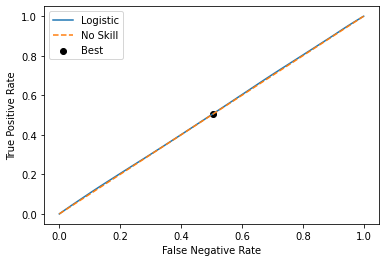

In [10]:
# ==================== Calculate optimal prediction threshold ====================

# ROC Curve
print('Calculating ROC curve...')
ns_probs = np.zeros(Y_val.shape)
ns_fpr, ns_tpr, _ = roc_curve(Y_val.flatten().astype(np.uint8), ns_probs.flatten())
fpr, tpr, roc_thresholds = roc_curve(Y_val.flatten().astype(np.uint8), preds_val.flatten())
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_roc_threshold = roc_thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_roc_threshold, gmeans[ix]))
plt.plot(fpr, tpr, label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Negative Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision Recall Curve
#print('Calculating Precision/Recall curve...')
#precision, recall, pr_thresholds = precision_recall_curve(Y_val.flatten().astype(np.uint8), preds_val.flatten())
#fscore = (2 * precision * recall) / (precision + recall + 0.01)
#ix = np.argmax(fscore)
#best_pr_threshold = pr_thresholds[ix]
#print('Best Threshold=%f, F-Score=%.3f' % (best_pr_threshold, fscore[ix]))
#no_skill = len(Y_val.flatten()[Y_val.flatten()==1]) / len(Y_val.flatten())
#plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
#plt.plot(recall, precision, label='Logistic')
#plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.legend()
#plt.show()

In [11]:
best_threshold = round(best_roc_threshold, 3)
#best_threshold = round(best_pr_threshold, 3)
print(best_threshold)
preds_val_t = (preds_val > best_threshold).astype(np.uint8)
preds_test_t = (preds_test > best_threshold).astype(np.uint8)

0.171


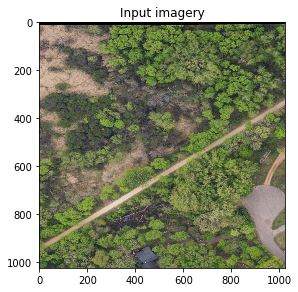

Mask coverage: 0.105


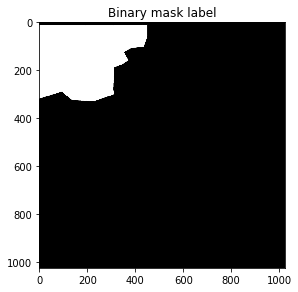

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [0 0 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
c:\Users\Carl\Desktop\spatial_computing\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


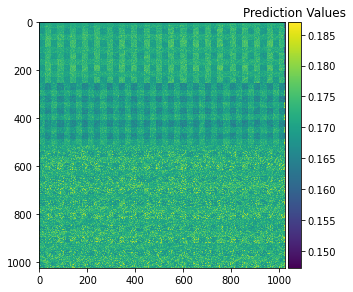

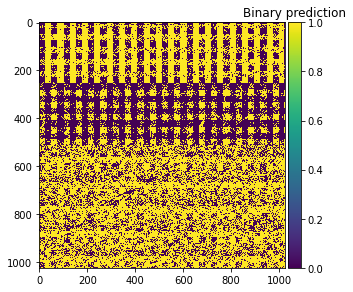

In [12]:
# ==================== Sanity check - validation ====================
ix = random.randint(0, len(X_val)-1)
imshow(X_val[ix][:,:,:3])
plt.title("Input imagery")
plt.show()
print("Mask coverage: %0.3f"%(np.mean(Y_val[ix])))
imshow(np.squeeze(Y_val[ix]))
plt.title("Binary mask label")
plt.show()
print(preds_val_t[ix])
imshow(np.squeeze(preds_val[ix]))
plt.title('Prediction Values')
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.title('Binary prediction')
plt.show()

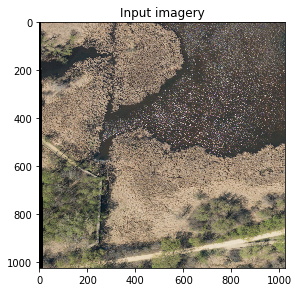

Mask coverage: 0.874


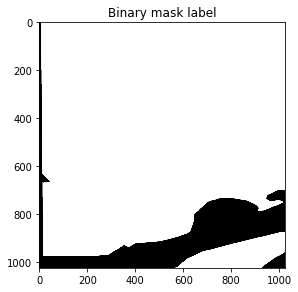

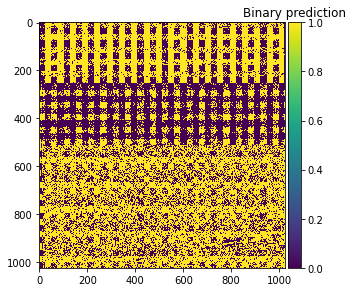

In [13]:
# ==================== Sanity check - test ====================
ix = random.randint(0, len(X_test)-1)
imshow(X_test[ix][:,:,:3])
plt.title("Input imagery")
plt.show()
print("Mask coverage: %0.3f"%(np.mean(Y_test[ix])))
imshow(np.squeeze(Y_test[ix]))
plt.title("Binary mask label")
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.title('Binary prediction')
plt.show()

In [ ]:
# ==================== Confusion matrix - test ====================
tn = fp = fn = tp = 0.
for ix in tqdm(range(len(preds_test_t))):
    tn_, fp_, fn_, tp_ = confusion_matrix(Y_test[ix].astype(int).flatten(), preds_test_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
    tn = tn + tn_
    fp = fp + fp_
    fn = fn + fn_
    tp = tp + tp_

print('\n', tn, fp, fn, tp)

In [ ]:
# ==================== Confusion matrix - validation ====================
tn = fp = fn = tp = 0.
for ix in tqdm(range(len(preds_val_t))):
    tn_, fp_, fn_, tp_ = confusion_matrix(Y_val[ix].astype(int).flatten(), preds_val_t[ix].astype(int).flatten(), labels=[0,1]).ravel()
    tn = tn + tn_
    fp = fp + fp_
    fn = fn + fn_
    tp = tp + tp_
    
print('\n', tn, fp, fn, tp)

In [ ]:
# Selecting test data samples
# Need to run once at the start
# print(img_mask_HCL_pair.keys)

# import shutil

# TEST_HCL_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_020/Test/img'
# TEST_HCL_MASK_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_020/Test/mask'

# TEST_HCR_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_021/Test/img'
# TEST_HCR_MASK_PATH = '/Users/jayantgupta/Desktop/Imagery/Wetland_Imagery/027_23_05_021/Test/mask'

# test_samples_HCL = random.choices(list(img_mask_HCL_pair.keys()), k=98)
# for sample in test_samples_HCL:
#     try:
#         img_path = img_mask_HCL_pair[sample][0]
#         img_test_path = os.path.join(TEST_HCL_PATH,img_path.split('/')[-1])
#         shutil.move(img_path, img_test_path)
#     #print(img_path)
#     #print(img_test_path)

#         mask_path = img_mask_HCL_pair[sample][1]
#         mask_test_path = os.path.join(TEST_HCL_MASK_PATH, mask_path.split('/')[-1])
#         shutil.move(mask_path, mask_test_path)
#     except:
#         print(sample)
#     #break;

# test_samples_HCR = random.choices(list(img_mask_HCR_pair.keys()), k=98)
# for sample in test_samples_HCR:
#     try:
#         img_path = img_mask_HCR_pair[sample][0]
#         img_test_path = os.path.join(TEST_HCR_PATH,img_path.split('/')[-1])
#         shutil.move(img_path, img_test_path)
    
#         mask_path = img_mask_HCR_pair[sample][1]
#         mask_test_path = os.path.join(TEST_HCR_MASK_PATH, mask_path.split('/')[-1])
#         shutil.move(mask_path, mask_test_path)    
#     except:
#         print(sample)